### Introduction

The object of this project is to create a simple anti-spam detector for text messages.  
The data that is being used for training and testing comes from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection).  
The file contains over 5000 text messages.

In [146]:
#Firstly, let's import some packages
import pandas as pd
import string
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
%matplotlib inline

In [122]:
#Now, let's see how big the data exactly is and how it looks like
messages = [line.rstrip() for line in open('SMS_Data/SMSSpamCollection')]
print(len(messages))

5574


In [123]:
for message_no, message in enumerate(messages[:10]):
    print(message_no, message)

0 ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
1 ham	Ok lar... Joking wif u oni...
2 spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
3 ham	U dun say so early hor... U c already then say...
4 ham	Nah I don't think he goes to usf, he lives around here though
5 spam	FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, Â£1.50 to rcv
6 ham	Even my brother is not like to speak with me. They treat me like aids patent.
7 ham	As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune
8 spam	WINNER!! As a valued network customer you have been selected to receivea Â£900 prize reward! To claim call 09061701461. Claim code KL341. Valid 1

In [124]:
#As we can see, this look like a TSV file with two columns. First one is a label, telling whether the message is a spam or a normal text ('ham'). Second is a message itself.
#Let's read the file using pandas
messages = pd.read_csv('SMS_Data/SMSSpamCollection', sep='\t', names=['label', 'message'])
messages.head(5)

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### Exploratory Data Analysys

In [125]:
#Let's see how the length of the message corresponds with the label category

#adding the length column
messages['length'] = messages['message'].apply(len)

In [126]:
#average length, shortest and longest messages
messages['length'].describe()

count    5572.000000
mean       80.489950
std        59.942907
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: length, dtype: float64

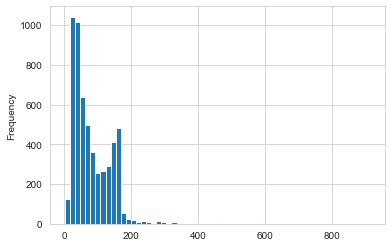

In [127]:
#Looks like there are two local peaks, one around 50 and one around 150 words 
sns.set_style('whitegrid')
messages['length'].plot(bins=60, kind='hist');

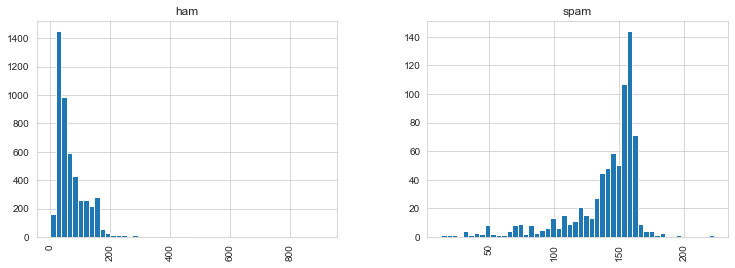

In [128]:
#It seems that spam messages tend to be longer than normal ones
sns.set_style('whitegrid')
messages.hist(column='length', by='label', bins=50,figsize=(12,4));

### Creating an anti-spam detector

#### Vectorizing

In [129]:
#Removing punctuation
def text_clean(text):
    no_punc = [character for character in text if character not in string.punctuation]
    no_punc = ''.join(no_punc)
    return [word for word in no_punc.split()]

In [130]:
#Creating a matrix where rows are the unique words in all the messages and columns are the messages
#Using CountVectorizer from SKLearn package with custom text_clean function
transformer = CountVectorizer(analyzer=text_clean).fit(messages['message'])
messages_trans = transformer.transform(messages['message'])

In [131]:
#There are 11 747 distinct words in all 5572 messages 
print(messages_trans.shape)

(5572, 11747)


#### Training a model

In [132]:
#splitting the data into train and test sets
msg_train, msg_test, label_train, label_test = train_test_split(messages_trans, messages['label'], test_size=0.3, random_state=101)

In [133]:
#There are 3900 train messages and 1672 test messages
print('Train messages:')
print(msg_train.shape[0])
print('Test messages:')
print(msg_test.shape[0])

Train messages:
3900
Test messages:
1672


In [134]:
#Training the model using Naive Bayes classifier
spam_detect_model = MultinomialNB().fit(msg_train, label_train)

In [135]:
#Evaluating how well it performs
all_predictions = spam_detect_model.predict(msg_test)
print('Confusion Matrix')
print(confusion_matrix(label_test, all_predictions))
print('\n')
print('Classification Report')
print(classification_report(label_test, all_predictions))

Confusion Matrix
[[1438   37]
 [  21  176]]


Classification Report
              precision    recall  f1-score   support

         ham       0.99      0.97      0.98      1475
        spam       0.83      0.89      0.86       197

    accuracy                           0.97      1672
   macro avg       0.91      0.93      0.92      1672
weighted avg       0.97      0.97      0.97      1672



Confusion Matrix tells that the model predicted 1614 values correctly and 58 incorrectly (37 ham messages classified as spam and 21 spam messages classified as ham).  

Classification Reports shows some more metrics.  
Precision tells that out of all the messages that the model predicted to be spam, only 83% was actual spam.  
Recall tells that of all the spam messages, model predicted it correctly only in 89%.  
F1-score is a metric that should be as close to 1 as possible.  
In this case the model is doing ok. Let's see if it can do even better.

### Optimization

To increase the performance of the model, I will add 2 more things to the process:  
1. Remove the stopwords using Natural Language Processing package
2. Apply TF-IDF (frequency-inverse document frequency) to even the relevance of the words  

I will also try a different classifier to see how that changes the outcome.

#### Vectorizing

In [109]:
#Rewriting the text_process function to include stopwords removal
def text_clean_opt(text):
    no_punc = [character for character in text if character not in string.punctuation]
    no_punc = ''.join(no_punc)
    return [word for word in no_punc.split() if word.lower() not in stopwords.words('english')]

In [110]:
#Creating a matrix where rows are the unique words in all the messages and columns are the messages
#Using CountVectorizer from SKLearn package with custom text_clean function
transformer_opt = CountVectorizer(analyzer=text_clean_opt).fit(messages['message'])
messages_trans_opt = transformer_opt.transform(messages['message'])

In [136]:
#There are 11 425 distinct words in all 5572 messages (322 stopwords removed)
print(messages_trans_opt.shape)

(5572, 11425)


In [137]:
#Applying TF_IDF
tfidf_transformer = TfidfTransformer().fit(messages_trans_opt)
messages_tfidf = tfidf_transformer.transform(messages_trans_opt)

#### Training a model

In [138]:
#splitting the data into train and test sets
msg_opt_train, msg_opt_test, label_opt_train, label_opt_test = train_test_split(messages_tfidf, messages['label'], test_size=0.3, random_state=101)

In [139]:
#There are 3900 train messages and 1672 test messages
print('Train messages:')
print(msg_opt_train.shape[0])
print('Test messages:')
print(msg_opt_test.shape[0])

Train messages:
3900
Test messages:
1672


In [140]:
#Training the model using Naive Bayes classifier
spam_detect_model_opt = MultinomialNB().fit(msg_opt_train, label_opt_train)

In [144]:
#Evaluating how well it performs
all_predictions_opt = spam_detect_model_opt.predict(msg_opt_test)
print('Confusion Matrix')
print(confusion_matrix(label_opt_test, all_predictions_opt))
print('\n')
print('Classification Report')
print(classification_report(label_opt_test, all_predictions_opt))
print('\n')

Confusion Matrix
[[1475    0]
 [  71  126]]


Classification Report
              precision    recall  f1-score   support

         ham       0.95      1.00      0.98      1475
        spam       1.00      0.64      0.78       197

    accuracy                           0.96      1672
   macro avg       0.98      0.82      0.88      1672
weighted avg       0.96      0.96      0.95      1672





There are no false positives, but the number of false negatives increased.  
That means the anti spam detector is more 'leaky' to spam, but it won't delete normal messages. 


In [147]:
#Let's see how it will perform with different classifier
#Training the model using Random Forest classifier
spam_detect_model_opt_forest = RandomForestClassifier().fit(msg_opt_train, label_opt_train)

#Evaluating how well it performs
all_predictions_opt_forest = spam_detect_model_opt_forest.predict(msg_opt_test)
print('Confusion Matrix')
print(confusion_matrix(label_opt_test, all_predictions_opt_forest))
print('\n')
print('Classification Report')
print(classification_report(label_opt_test, all_predictions_opt_forest))
print('\n')


Confusion Matrix
[[1472    3]
 [  46  151]]


Classification Report
              precision    recall  f1-score   support

         ham       0.97      1.00      0.98      1475
        spam       0.98      0.77      0.86       197

    accuracy                           0.97      1672
   macro avg       0.98      0.88      0.92      1672
weighted avg       0.97      0.97      0.97      1672





Now it looks like this has the best performance so far. Only 49 incorrect predictions.  

#### Conclusion

There is a lot of optimization possibilities to try with this project.  
Firstly, there are lots of other text pre-processing techniques that can be applied to the text before vectorizing it (such as ['stemming'](https://en.wikipedia.org/wiki/Stemming)).  
Secondly, a lot more different classifiers that can prove to be more efficient in this specific situation.  
Also, deep understanding of the data can help to know what results should be achieved.